# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this project, the LeNet architecture is modified slightly and data preproccessing is used to achieve 95% validation accuracy on a Traffic Sign data set of 43 different classes. A project writeup is included with discussions of data preprocessing, architecture modifications, and results.

---
## Step 0: Load The Data

In [141]:
# Load pickled data
import pickle

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### 0.1 Check the data

In [142]:
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Basic Summary of the Data Set

In [143]:
n_train = len(X_train)

n_validation = len(X_valid)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(train['labels'])) # Convert list to a set to determine number of unique elements

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [144]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

### Let's see if the images are equally distributed across classes

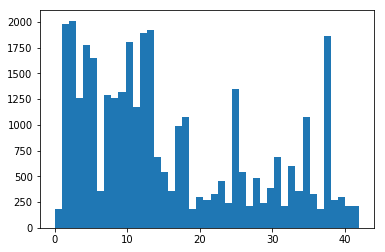

In [145]:
plt.hist(y_train, bins=n_classes);

Unfortunately, they're not. There seems to be a large variance, from 2,000 all the way down to 200.

### Let's view a few random images from the training set

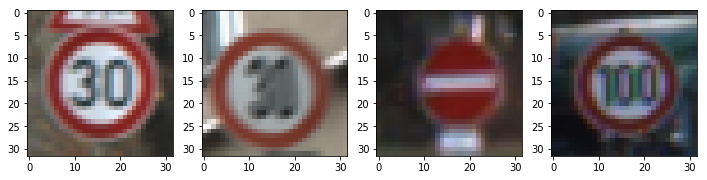

In [146]:
import random

rows = 1
figsize=(12,6)
f = plt.figure(figsize=figsize)
numImages = 4
for i in range(numImages):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    sp = f.add_subplot(rows, numImages, i+1) # Row and Column Size, and which subplot to put the pic in
    plt.imshow(image)

### View images with specific labels

This next section finds the a given number of signs of a given label and plots them. This is useful for visualizing what a specific sign looks like.

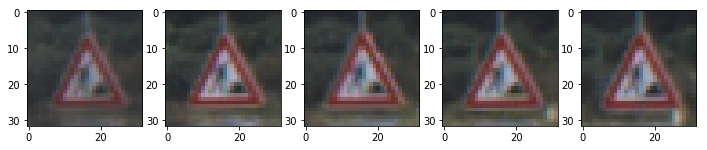

In [147]:
sign_ID = 25
num_of_signs = 5
counter = 0

rows = 1
figsize=(12,6) # How large the images are displayed
f = plt.figure(figsize=figsize)

for i in range(len(X_train)):
    if y_train[i] == sign_ID:
        counter += 1
        image = X_train[i]
        sp = f.add_subplot(rows, num_of_signs, counter)
        plt.imshow(image)
    if counter >= num_of_signs:
        break

----

## Step 2: Design and Test a Model Architecture

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

In [148]:
import numpy as np
import random

In [149]:
X_gray_train = X_train
X_gray_valid = X_valid
X_gray_test = X_test

In [150]:
from sklearn.utils import shuffle

X_gray_train, y_train = shuffle(X_gray_train, y_train)

### Model Architecture

Basic imports and parameter setting

In [151]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 30
BATCH_SIZE = 128
rate = 0.001

### Data Preprocessing

I chose two preprocessing steps:
1. RGB -> Grayscale
1. Data normalization

I chose grayscale as the above linked paper mentioned it was a good option. Normalization is required for this project, but it's also a good idea in general, so it was an obvious choice as well.

In [152]:
def preprocess(x):
    '''Preprocess image data using Tensorflow methods'''
    gray_images = tf.image.rgb_to_grayscale(x)

    # Dim is deprecated in favor of axis, but this system has an older version of Tensorflow
    normalized =  tf.nn.l2_normalize(gray_images, dim=2)
    return normalized

### The Network Itself

In [165]:
def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables 
    # for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Dropout Layer to prevent overfitting
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout Layer to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout Layer to prevent overfitting
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43 different signs.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

Some placeholders to be used later

In [154]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### The Training Pipeline

In [155]:
logits = LeNet(preprocess(x))
# logits = LeNet((x))

softmax = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax, k = 5)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)

# Adam Optimizer does learning rate decay automatically, no point in adding it manually
optimizer = tf.train.AdamOptimizer(learning_rate = rate) 

training_operation = optimizer.minimize(loss_operation)

### The Evaluation Pipeline

In [156]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### The Train / Validate code

In [158]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_gray_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_gray_train, y_train = shuffle(X_gray_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_gray_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        training_accuracy = evaluate(batch_x, batch_y)
        validation_accuracy = evaluate(X_gray_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))        
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.261
Validation Accuracy = 0.280

EPOCH 2 ...
Training Accuracy = 0.613
Validation Accuracy = 0.556

EPOCH 3 ...
Training Accuracy = 0.748
Validation Accuracy = 0.671

EPOCH 4 ...
Training Accuracy = 0.784
Validation Accuracy = 0.754

EPOCH 5 ...
Training Accuracy = 0.874
Validation Accuracy = 0.797

EPOCH 6 ...
Training Accuracy = 0.901
Validation Accuracy = 0.829

EPOCH 7 ...
Training Accuracy = 0.892
Validation Accuracy = 0.850

EPOCH 8 ...
Training Accuracy = 0.901
Validation Accuracy = 0.863

EPOCH 9 ...
Training Accuracy = 0.937
Validation Accuracy = 0.872

EPOCH 10 ...
Training Accuracy = 0.901
Validation Accuracy = 0.881

EPOCH 11 ...
Training Accuracy = 0.955
Validation Accuracy = 0.881

EPOCH 12 ...
Training Accuracy = 0.946
Validation Accuracy = 0.887

EPOCH 13 ...
Training Accuracy = 0.991
Validation Accuracy = 0.910

EPOCH 14 ...
Training Accuracy = 0.955
Validation Accuracy = 0.905

EPOCH 15 ...
Training Accuracy = 0.982
Valid

### Once the validation is sufficient, it's time to test

In [160]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_gray_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.924


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

First step: read in each image from the file.

Second step: resize each image to be `32x32`

In [161]:
import matplotlib.image as mpimg
import cv2

image_ids = [1, 14, 25, 33, 40]
resized = []

for file in image_ids:
    path = 'signs/' + str(file) + '.jfif'
    image = mpimg.imread(path)
    resized.append(cv2.resize(image, (32, 32)))

With each file available, let's view them:

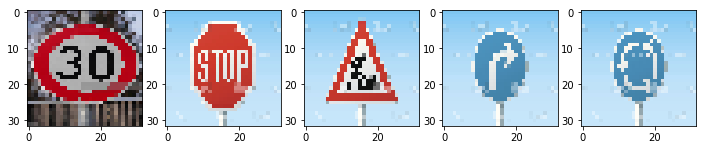

In [162]:
rows = 1
figsize=(12,6)
f = plt.figure(figsize=figsize)
numImages = 4
for i, sign in enumerate(resized):
    sp = f.add_subplot(rows, len(signs), i+1) # Row and Column Size, and which subplot to put the pic in
    plt.imshow(sign)

They're definitely a little cleaner than the original imageset I trained on. Let's see how that impacts the output.

Last Step: convert from list to numpy array

In [163]:
image_set_shape = (len(image_ids),) + (resized[0].shape)
image_set = np.empty(image_set_shape)

for i in range(len(image_ids)):
    image_set[i] = resized[i]

### Predict the Sign Type for Each Image

In [164]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_softmax_logits = sess.run(softmax, feed_dict={x: image_set, keep_prob: 1.0})
    test_top_k = sess.run(top_k, feed_dict={x: image_set, keep_prob: 1.0})

    test_accuracy = evaluate(image_set, image_ids)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print(test_top_k)

Test Accuracy = 0.600
TopKV2(values=array([[ 0.7802524 ,  0.05389767,  0.05094699,  0.03012216,  0.02999884],
       [ 0.82714039,  0.08114917,  0.05321359,  0.00913313,  0.00843911],
       [ 0.56387508,  0.36709324,  0.0376259 ,  0.0097688 ,  0.00720833],
       [ 0.18820699,  0.122809  ,  0.09353912,  0.07572132,  0.07135051],
       [ 0.83938819,  0.04383087,  0.04247151,  0.01763812,  0.0109753 ]], dtype=float32), indices=array([[ 1,  4,  2,  5,  0],
       [14, 34, 38, 35, 13],
       [25, 21, 30, 19, 31],
       [12, 40, 11, 34, 30],
       [12, 40, 17,  1, 13]], dtype=int32))


### 60% Accuracy on images found from Google Images

Considering the differences between the imageset and what I found on Google, that's not bad. 

The softmax probabilities are printed above, and I'll discuss them in the project writeup.